# 목적
- PEFT 추가 샘플코드입니다.
  - 멀티모달 모델 qwen3-vl, 4bit 양자화 모델 입니다.
  - unsloth 공식문서 코드를 편집해서 만들었습니다.

<br/>

- 모델 설명
  - 포켓몬 이미지를 입력하면 --> 포켓몬의 이름과 속성이 출력되는 모델

# 설치

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.0
!pip install --no-deps trl==0.22.2

# 모델준비
- Qwen3-VL 4bit 양자화
- T4 GPU 켜주세요

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.8: Fast Qwen3_Vl patching. Transformers: 4.57.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

# LoRA 어댑터

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

# 포켓몬 데이터
- 영어이름, 속성, 소개 데이터

In [4]:
from datasets import load_dataset
dataset = load_dataset("tungdop2/pokemon", split = "train")

README.md:   0%|          | 0.00/794 [00:00<?, ?B/s]

data/train-00000-of-00001-5e017125a702cf(…):   0%|          | 0.00/163M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1271 [00:00<?, ? examples/s]

# 데이터 출력해보기
- 아르세우스 : 전설의 포켓몬. (포켓몬계의 단군 할아버지)

In [5]:
dataset

Dataset({
    features: ['image', 'name', 'type_1', 'type_2', 'caption'],
    num_rows: 1271
})

arceus
normal
None
a white and gold creature with a long tail and a green gem on its head.


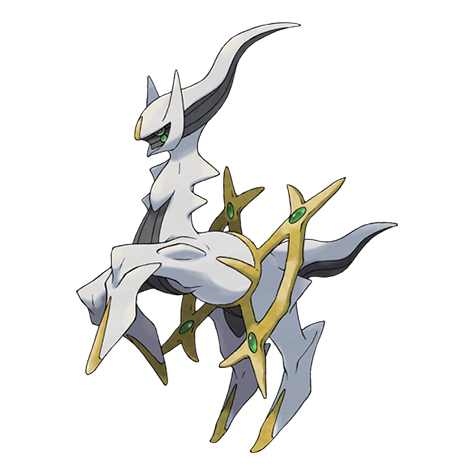

In [6]:
id = 36
print(dataset[id]["name"])
print(dataset[id]["type_1"])
print(dataset[id]["type_2"])
print(dataset[id]["caption"])
dataset[id]["image"]

# 모델이 원하는 입력 데이터 포맷

In [7]:
instruction = "이 포켓몬의 이름과 속성들을 말해줘, 한줄 요약"

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text",
                 "text": f"그의 이름은 {sample['name']} 이고, {sample['type_1']} / {sample.get('type_2', '')} 속성이지".strip()}
            ]
        }
    ]
    return {"messages": conversation}

In [8]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

# 변경 완료된 포맷 확인

In [9]:
converted_dataset[id]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': '이 포켓몬의 이름과 속성들을 말해줘, 한줄 요약'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=475x475>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '그의 이름은 abomasnow-mega 이고, grass / ice 속성이지'}]}]}

# 파인튜닝 하기전에, 한번 확인해보기
- 모델이 상상해서 대답합니다.

In [10]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[id]["image"]
instruction = "이 포켓몬의 이름과 속성들을 말해줘, 한줄 요약"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

이 포켓몬은 **하크니어**(Xerneas)로, **그리스어로 '행성'을 의미**하는 'Xerneas'는 이 포켓몬이 '생명의 힘'을 지닌 신화적 존재라는 뜻입니다.  
**속성은 초원(Grass)**이고, **공격형**으로 **특성은 '생명의 힘'(Life Orb)**이 적용되어 모든 공격에 생명력 100%를 잃게 됩니다.  
하크니어는 자연과 생명


# 학습 세팅

In [11]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 20,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [12]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,271 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,346,944 of 8,818,470,640 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.244600
2,1.231600
3,1.169100
4,1.149200
5,1.052100
6,0.883900
7,0.674500
8,0.588300
9,0.459600
10,0.438700


Step,Training Loss
1,1.244600
2,1.231600
3,1.169100
4,1.149200
5,1.052100
6,0.883900
7,0.674500
8,0.588300
9,0.459600
10,0.438700


# 추론해보기
- 결과 : 학습된 형태의 대답할 확률은 높고, 올바른 속성을 말할 확률은 낮은 편입니다.
- 성능을 올리기 위해서 step 수, 학습률 조율, 데이터 증강을하면 잘 됩니다.

=======정답 Label=========
arceus
normal
None
a white and gold creature with a long tail and a green gem on its head.
=======추론 시작==========
그의 속성은 그의 속성은 Psychic / Fairy이고, 그의 이름은 arceus 이다<|im_end|>


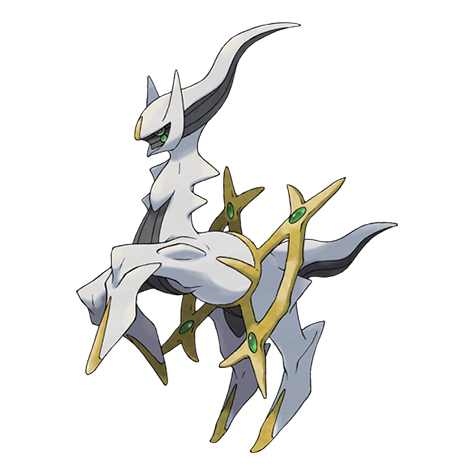

In [14]:
FastVisionModel.for_inference(model) # Enable for inference!

# 정답 Label
print('=======정답 Label=========')
print(dataset[id]["name"])
print(dataset[id]["type_1"])
print(dataset[id]["type_2"])
print(dataset[id]["caption"])


print('=======추론 시작==========')
# 여기서 부터 추론 시작
image = dataset[id]["image"]
instruction = "이 포켓몬의 이름과 속성들을 말해줘, 한줄 요약"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

dataset[id]["image"]